In [1]:
import os, sys

def get_root_path(search_word):
    """ Búsqueda hacia atrás de un directorio con nombre search_word. """
    cwd = os.getcwd()
    while str(os.getcwd()).split('/')[-1] != search_word:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path('TFM_StockForecast')

sys.path.insert(0, ROOT_DIR) # Poner en el primer lugar del PATH (evitar paquetes con mismos nombres en otros directorios)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.load_data import load_csv, load_data
from src.prepare_data import prepare_train_data

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_descompose(serie, period):
    
    result = seasonal_decompose(serie, model='additive', period=period)
    
    plt.figure(figsize=(20,40))
    plt.subplot(4,1,1)
    result.observed.plot(title='Observed')
    plt.subplot(4,1,2)
    result.trend.plot(title='Trend')
    plt.subplot(4,1,3)
    result.seasonal.plot(title='Seasonal - Period {}'.format(period))
    plt.subplot(4,1,4)
    result.resid.plot(title='Residual')
    plt.tight_layout()

In [42]:

#import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
import matplotlib.pyplot as plt # to graphics plot
import seaborn as sns # a good library to graphic plots

### GRAPHICAL DATA EXPLORATORY - NO CATEGORICAL DATA

from scipy.stats import norm, kurtosis, skew
def plotHist(data,n_bins=None, normal=True, stats=True):
    """
    if n_bins = None : Freedman-Diaconis rule
    """
    if normal:
        ax = sns.distplot(data, bins = n_bins, fit=norm, fit_kws={"color":"red"})
        ax.legend()
    else:
        ax = sns.distplot(data, bins = n_bins)
    #plt.title('Histograma para {}'.format(data.name))
    if stats:
        ax.text(0.8, 0.9,'kurtosis: {}'.format(round(kurtosis(data),2)),
                transform=ax.transAxes)
        ax.text(0.8, 0.95, 'skewness: {}'.format(round(skew(data),2)),
               transform=ax.transAxes)
        ax.text(0.05, 0.95,'mean: {}'.format(round(data.mean(),2)),
                transform=ax.transAxes)
        ax.text(0.05, 0.9, 'sd: {}'.format(round(data.std(),2)),
                transform=ax.transAxes)
    
    
def plotECDF(data):
    """
    Plot ECDF for a variable and the
    ECDF for a normal distribution with same mean and std
    """
    # create normal distribution with same mean and std as data
    normal = np.random.normal(np.mean(data), np.std(data), 1000)
    # Compute ecdf and plot it in red line
    xvers, yvers = np.sort(normal), np.arange(1, len(normal)+1) / len(normal)
    plt.plot(xvers, yvers, color='red', label='normal')
    xvers, yvers = np.sort(data), np.arange(1, len(data)+1) / len(data)
    plt.plot(xvers, yvers, marker = '.', linestyle = 'none', label=data.name)
    plt.xlabel(data.name)
    plt.ylabel('ECDF')
    plt.title('ECDF para {}'.format(data.name))
    plt.legend()
    
def plotBoxSwarm(data):
    sns.boxplot(data)
    ax = sns.swarmplot(data, color=".2", alpha=0.3)
    plt.title('Boxplot/Swarmplot para {}'.format(data.name))
    ytext=0.95
    for quan, name in zip([0, 0.25, 0.5, 0.75, 1],['min','25%','median','75%','max']):
        ax.text(0.05, ytext,name +': {}'.format(round(data.quantile(quan),2)),
            transform=ax.transAxes)
        ytext -= 0.05
    
def plotViolinStrip(data): 
    sns.violinplot(data, color = 'lightgray', inner=None)
    # Overlay a strip plot on the violin plot
    sns.stripplot(data, jitter=True,size=1.5)
    plt.title('Violin/Stritplot para {}'.format(data.name))   
    

In [117]:
df = load_csv("stock")
df.head()

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1082
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 13017
Dataset stock loaded. Shape: (26220, 3)



,fecha,producto,udsstock
0,2019-06-05,38,2640
1,2019-06-05,91,104
2,2019-06-05,49,222
3,2019-06-05,3,27112
4,2019-06-05,7,208


In [45]:
df = load_csv("stock")
df = df.groupby(["producto","fecha"])['udsstock'].agg(['min',"mean", 'max']).reset_index()

ventas = load_csv("ventas")

#df = df.merge(ventas, on=["fecha","producto"])

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1082
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 13017
Dataset stock loaded. Shape: (26220, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

In [46]:
ts = df.set_index("fecha")
ts.head()

,producto,min,mean,max
fecha,,,,
2019-06-05,1,13919.0,18275.5,22632.0
2019-06-11,1,2224.0,2920.0,3616.0
2019-06-12,1,5127.0,6731.5,8336.0
2019-06-13,1,5515.0,7241.5,8968.0
2019-06-14,1,2932.0,3850.0,4768.0


KeyboardInterrupt: 

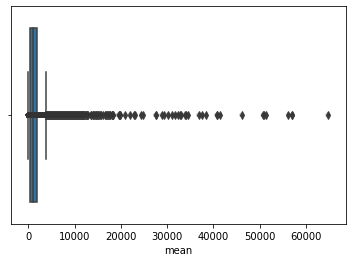

In [53]:
plotBoxSwarm(ts["mean"])

# Ejemplos de series de stock

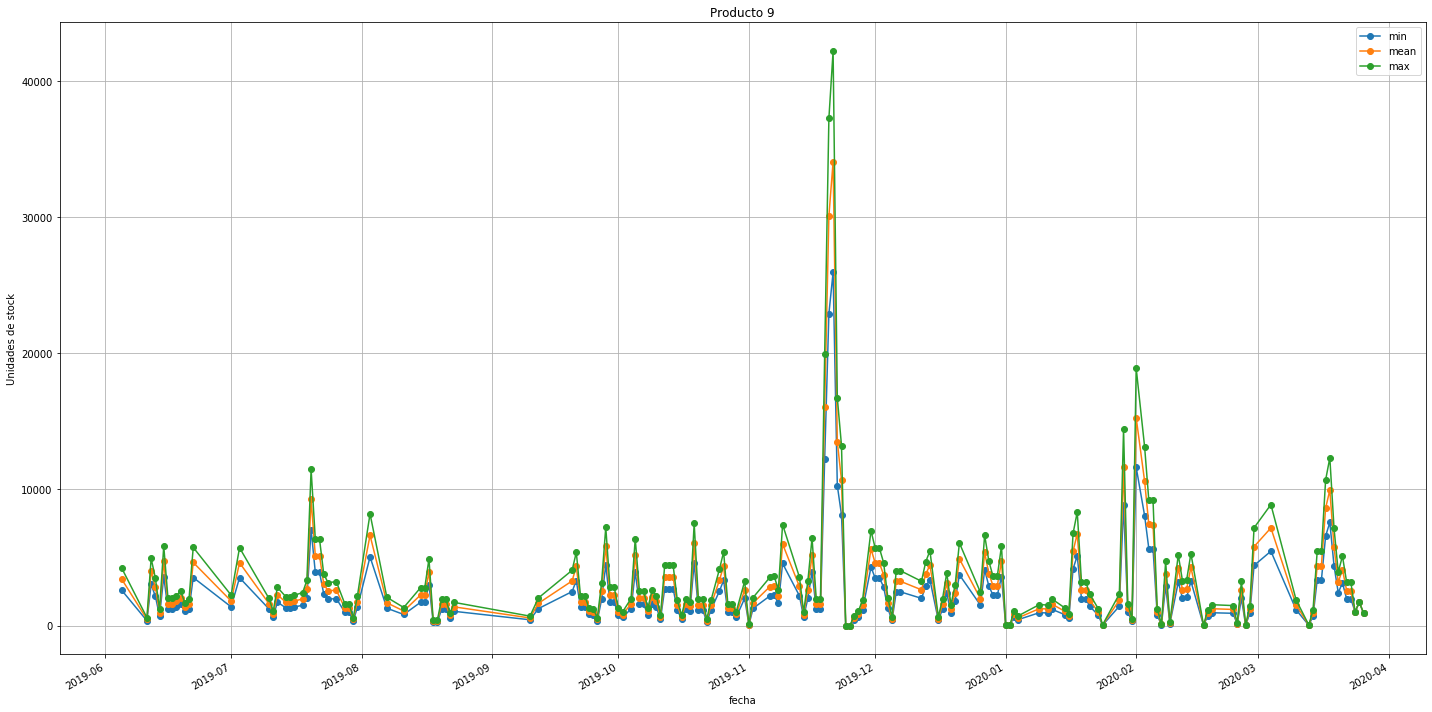

In [65]:
prod = "9"

ts30 = ts.loc[ts.producto == prod].plot(figsize=(20,10), marker='o')
plt.title("Producto {}".format(prod))
plt.ylabel("Unidades de stock")
plt.grid()
plt.tight_layout()
plt.savefig("reports/eda/timeseries_{}.png".format(prod))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


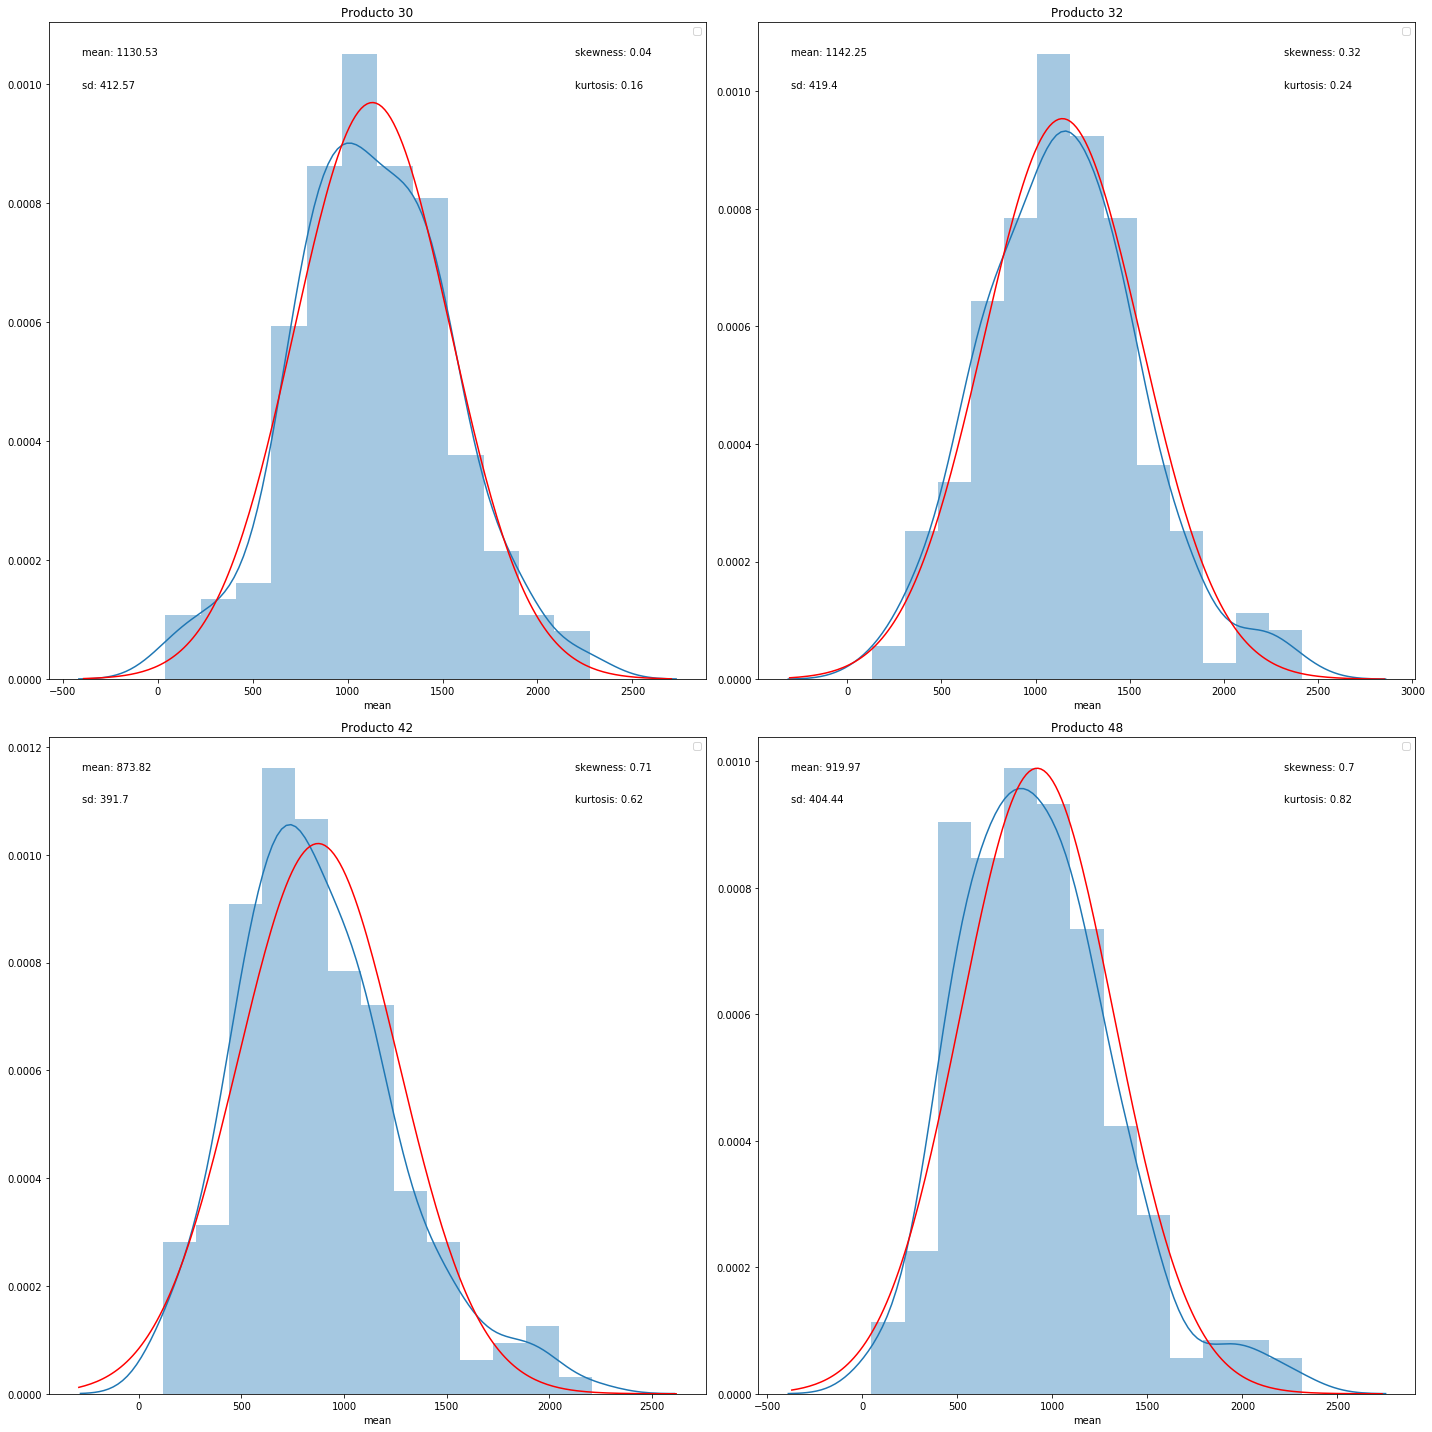

In [56]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plotHist(ts.loc[ts.producto == "30", "mean"])
plt.title("Producto 30")

plt.subplot(2,2,2)
plotHist(ts.loc[ts.producto == "32", "mean"])
plt.title("Producto 32")

plt.subplot(2,2,3)
plotHist(ts.loc[ts.producto == "42", "mean"])
plt.title("Producto 42")

plt.subplot(2,2,4)
plotHist(ts.loc[ts.producto == "48", "mean"])
plt.title("Producto 48")
plt.tight_layout()
plt.savefig("reports/eda/hists_grupo1.png")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


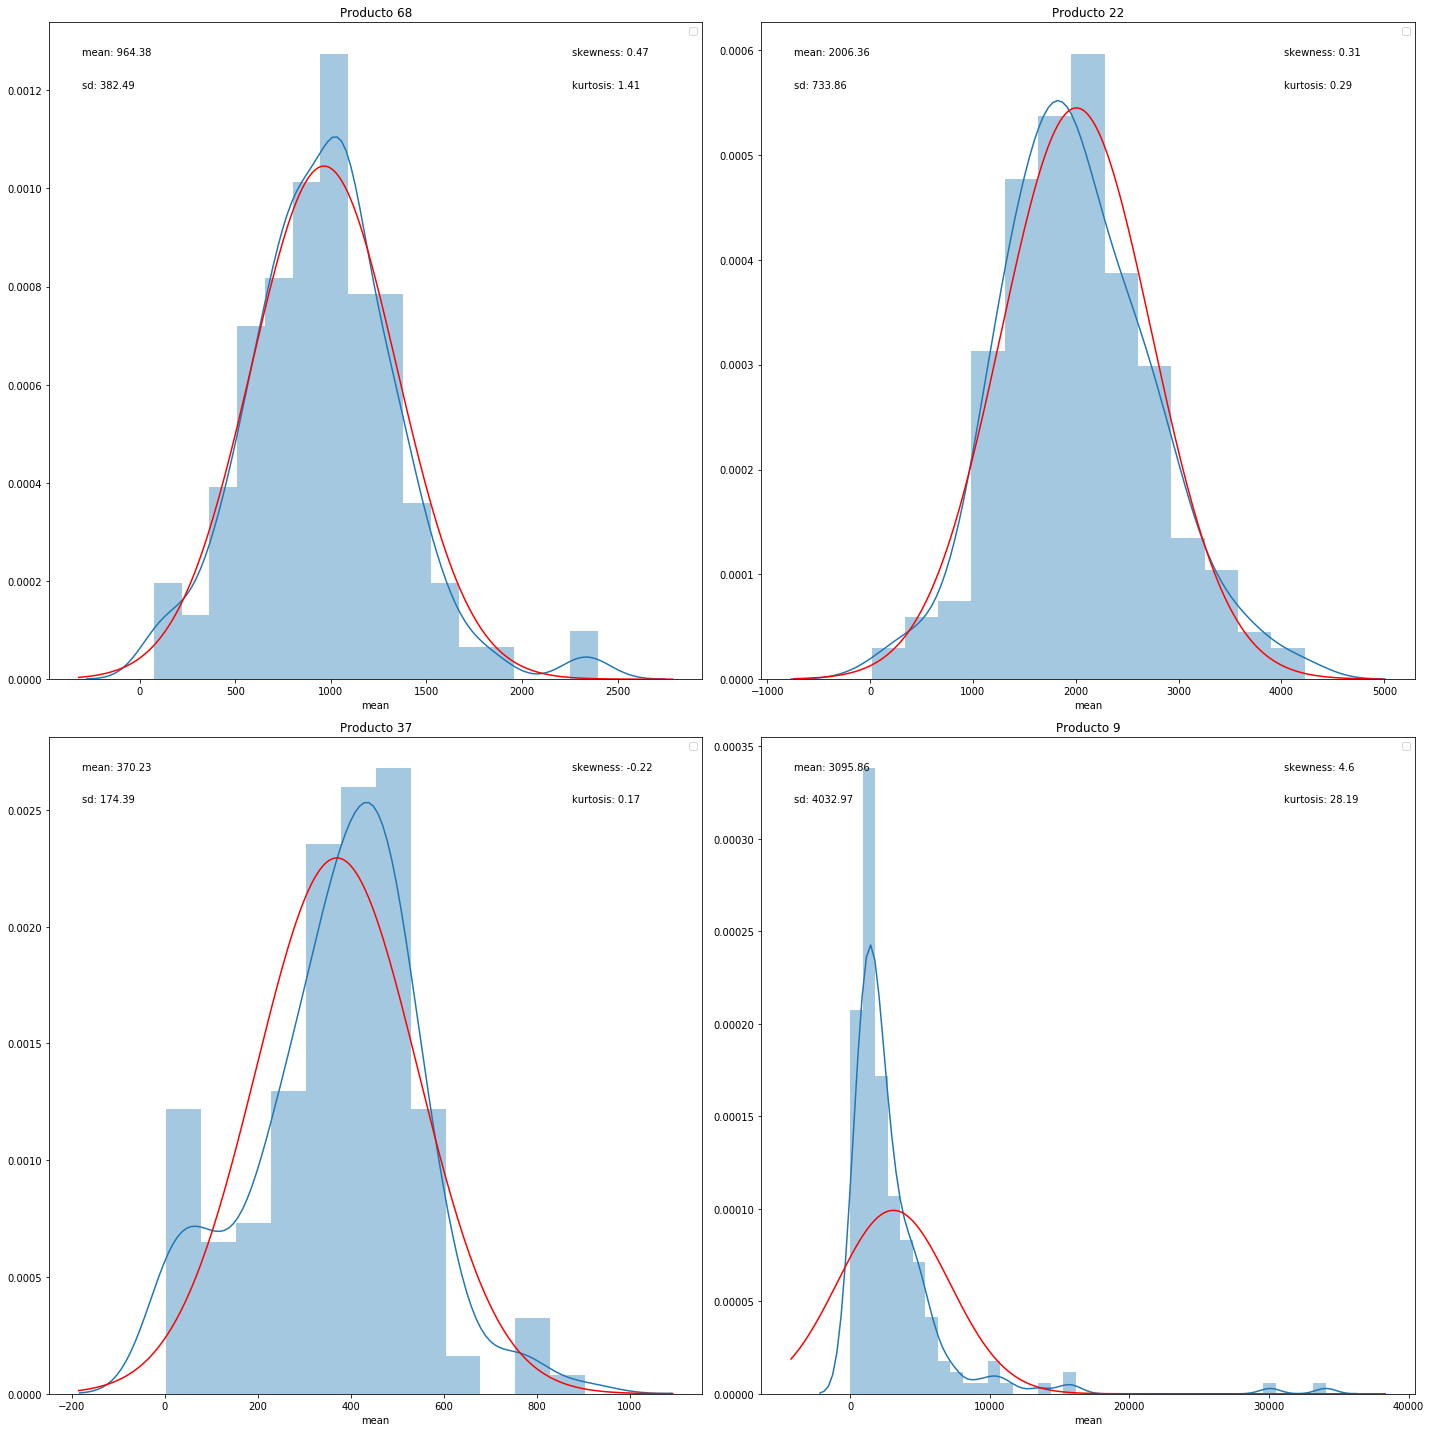

In [58]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plotHist(ts.loc[ts.producto == "68", "mean"])
plt.title("Producto 68")

plt.subplot(2,2,2)
plotHist(ts.loc[ts.producto == "22", "mean"])
plt.title("Producto 22")

plt.subplot(2,2,3)
plotHist(ts.loc[ts.producto == "37", "mean"])
plt.title("Producto 37")

plt.subplot(2,2,4)
plotHist(ts.loc[ts.producto == "9", "mean"])
plt.title("Producto 9")
plt.tight_layout()
plt.savefig("reports/eda/hists_ejs.png")

# Time Series

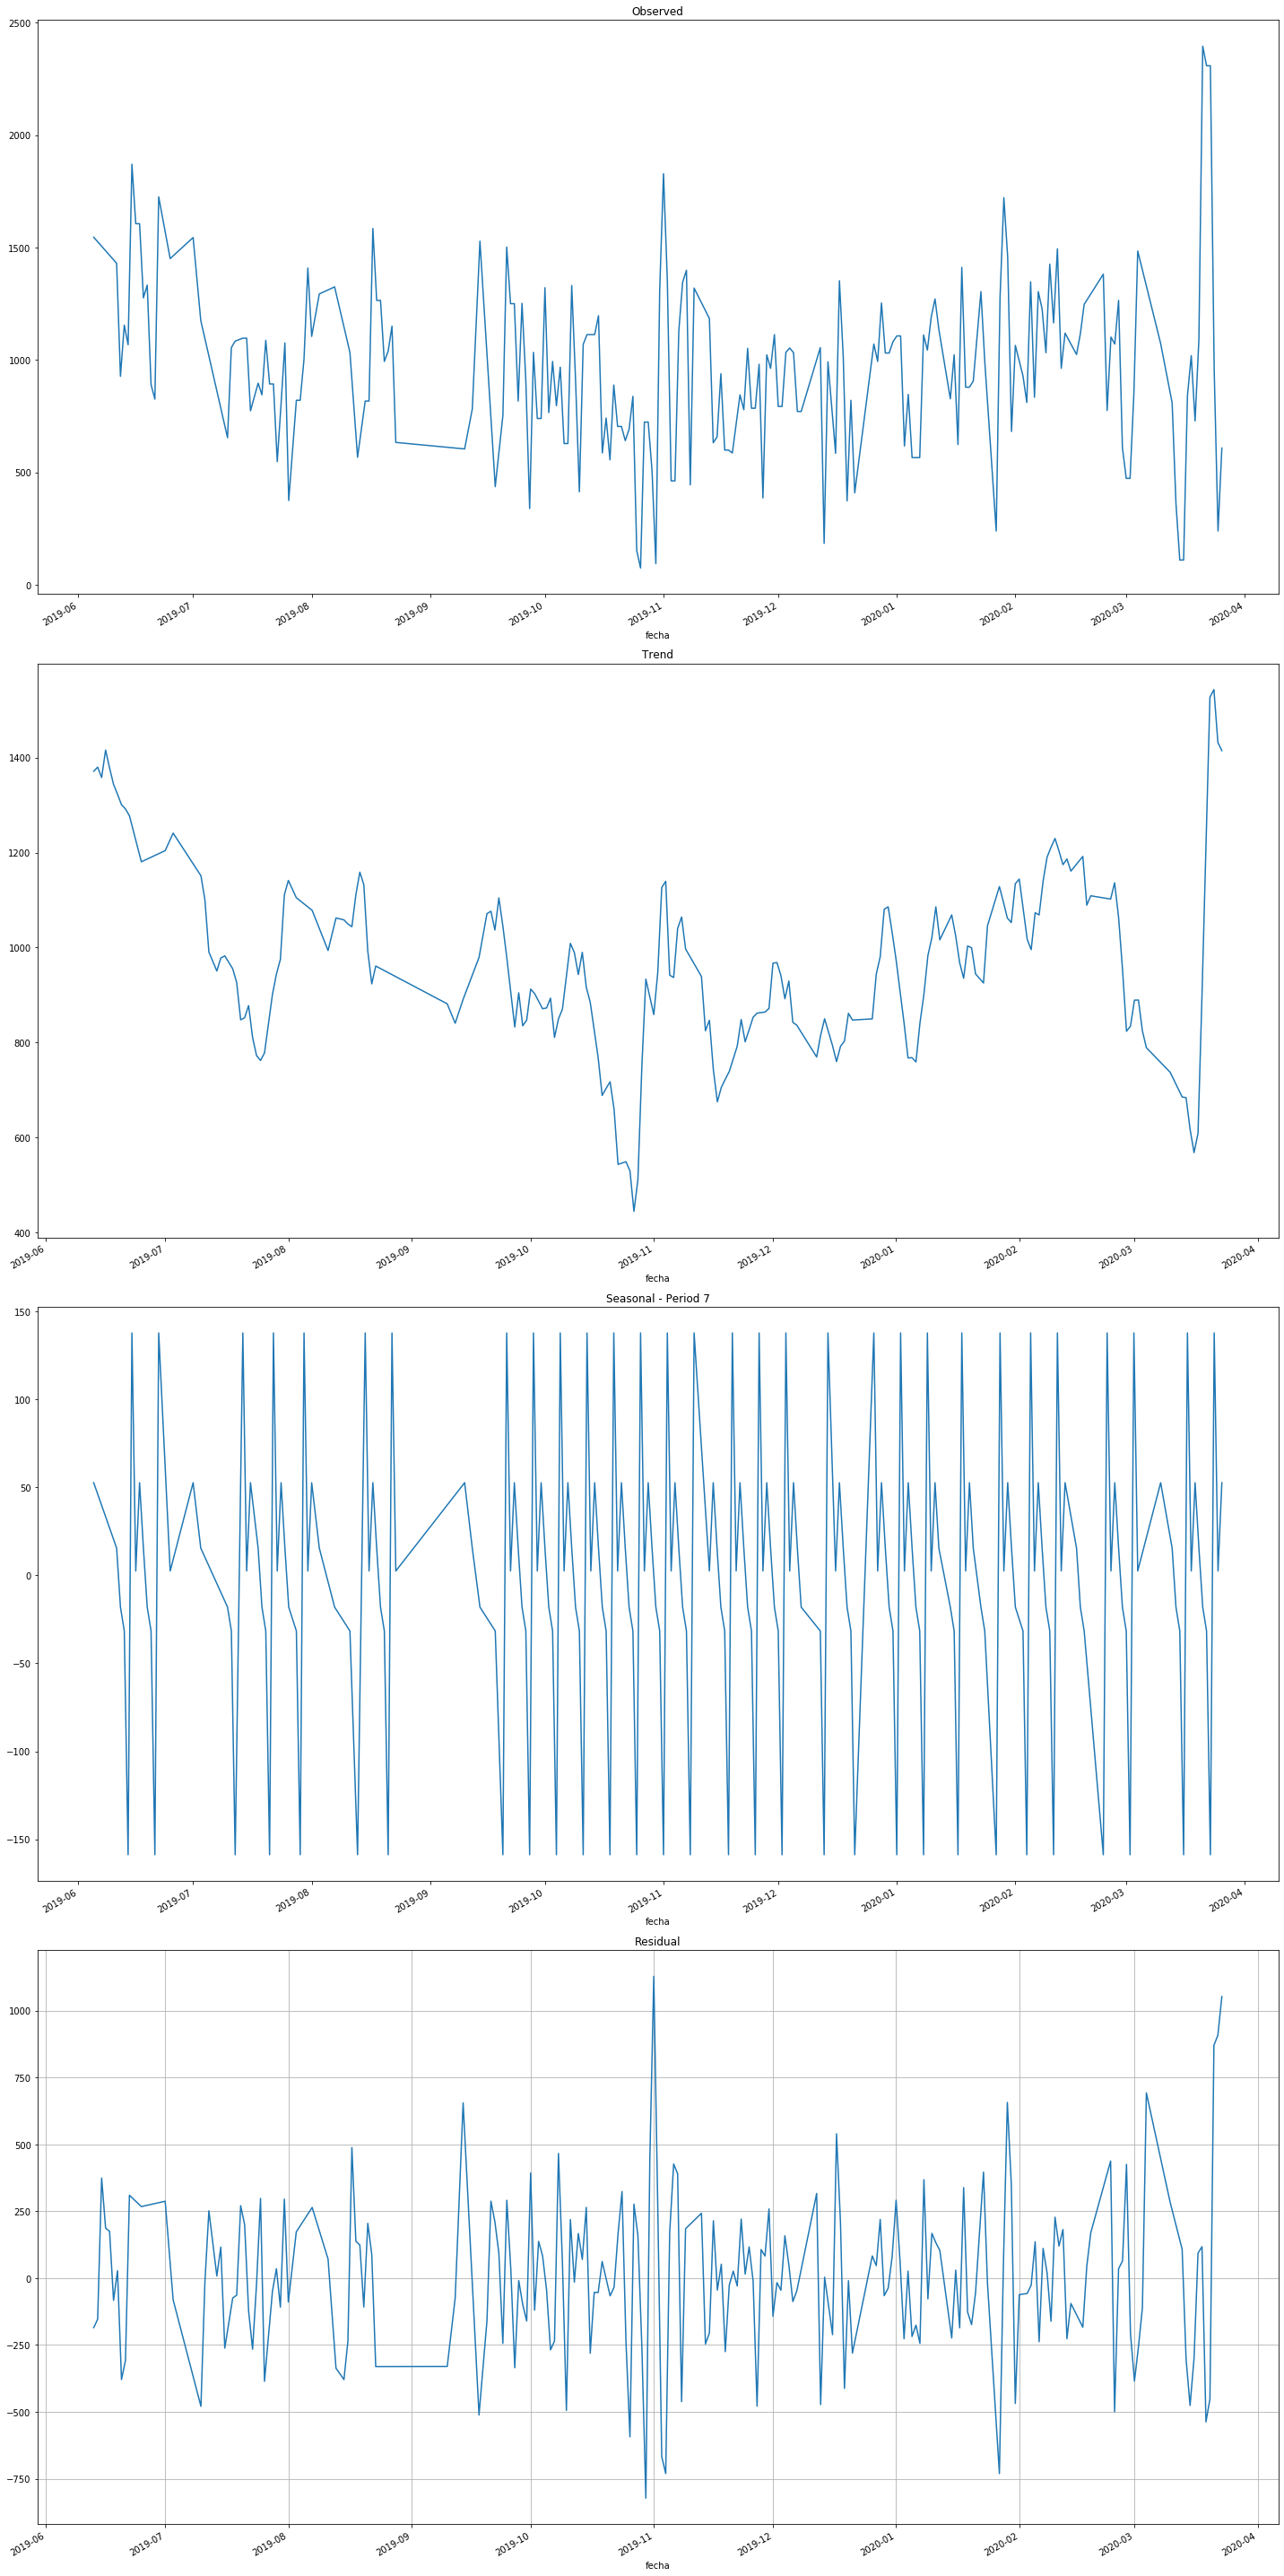

In [75]:
prod = "68"
serie = ts.loc[ts.producto == prod, "mean"]
plot_seasonal_descompose(serie, 7)
plt.grid()
plt.tight_layout()
plt.savefig("reports/eda/ts_descomposition_{}.png".format(prod))




# Dia de la semana

In [77]:
def plotBar(data, order = False):
    """
    Plotea un barchart horizontal para series categoricas
    """
    # Calculamos las proporciones y asignamos labels y values
    counts = data.value_counts().sort_values(ascending=True)
    df = pd.DataFrame(data=np.vstack([counts.index, counts.values]).T, columns=['category', 'counts'])
    if order:
        df = df.sort_values('category', ascending=True)
    else:
        df = df.sort_values('counts', ascending=False)
    # Ploteamos barplot
    sns.barplot(x='counts', y='category', data=df, order=df['category'],
                edgecolor='black', alpha=0.8, orient='h')

    # Añadimos las labels numericas
    for i, v in enumerate(df['counts']):
        plt.text(v + 0.5, i + .1, str(v), color='black', alpha=0.8)

    # Añadimos titulo y ejes
    plt.xlabel('Number of ocurrencies')
    plt.title('Frequency distribution for {}'.format(data.name))

In [84]:
main_df = load_data()

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1082
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 13017
Dataset stock loaded. Shape: (26220, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['missing'] = (ts.udsstock.isna()) * 1
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data["roll4wd_" + col] = day_data.loc[(day_data.festivo == 0), col].rolling(4, win_type='triang', min_periods=1).mean()
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_va

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and 

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and 

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

In [89]:
serie

,weekday,udsstock
0,0,927.250000
1,1,966.968750
2,2,1010.090909
3,3,959.878788
4,4,826.062500
5,5,1139.379310
6,6,918.208333


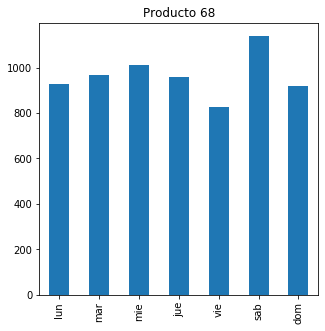

In [108]:
prod = "68"
serie = main_df.loc[main_df.producto == prod]
# plot_seasonal_descompose(serie, 7)
# plt.grid()
# plt.tight_layout()
# plt.savefig("reports/eda/ts_descomposition_{}.png".format(prod))
serie = serie.groupby("weekday")["udsstock"].mean()
serie.index = ["lun","mar","mie","jue","vie","sab","dom"]
serie.plot(kind='bar', figsize=(5,5))
#plt.tight_layout()
plt.title("Producto {}".format(prod))
plt.savefig("reports/eda/weekday_{}.png".format(prod))

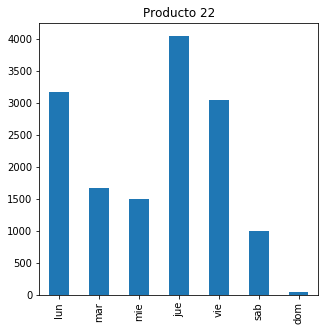

In [115]:
for prod in ["68","9","37","22"]:
    serie = main_df.loc[main_df.producto == prod]
    # plot_seasonal_descompose(serie, 7)
    # plt.grid()
    # plt.tight_layout()
    # plt.savefig("reports/eda/ts_descomposition_{}.png".format(prod))
    serie = serie.groupby("weekday")["udsventa"].mean()
    serie.index = ["lun","mar","mie","jue","vie","sab","dom"]
    serie.plot(kind='bar', figsize=(5,5))
    #plt.tight_layout()
    plt.title("Producto {}".format(prod))
    plt.savefig("reports/eda/weekday_ventas_{}.png".format(prod))

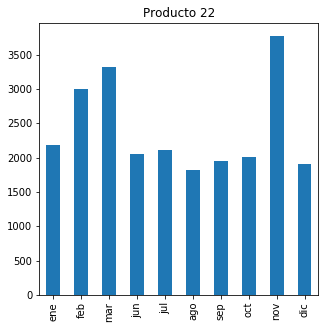

In [116]:
for prod in ["68","9","37","22"]:
    serie = main_df.loc[main_df.producto == prod]
    # plot_seasonal_descompose(serie, 7)
    # plt.grid()
    # plt.tight_layout()
    # plt.savefig("reports/eda/ts_descomposition_{}.png".format(prod))
    serie = serie.groupby("month")["udsventa"].mean()
    serie.index = ["ene","feb","mar","jun","jul","ago","sep","oct","nov","dic"]
    serie.plot(kind='bar', figsize=(5,5))
    #plt.tight_layout()
    plt.title("Producto {}".format(prod))
    plt.savefig("reports/eda/month_ventas_{}.png".format(prod))

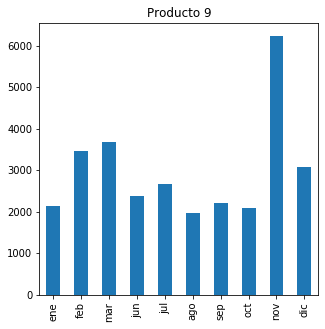

In [114]:
prod = "9"
serie = main_df.loc[main_df.producto == prod]
# plot_seasonal_descompose(serie, 7)
# plt.grid()
# plt.tight_layout()
# plt.savefig("reports/eda/ts_descomposition_{}.png".format(prod))
serie = serie.groupby("month")["udsstock"].mean()
serie.index = ["ene","feb","mar","jun","jul","ago","sep","oct","nov","dic"]
serie.plot(kind='bar', figsize=(5,5))
#plt.tight_layout()
plt.title("Producto {}".format(prod))
plt.savefig("reports/eda/month{}.png".format(prod))